<a href="https://www.kaggle.com/code/tenzinjampa/calorie-predictor?scriptVersionId=242031775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# Calorie Predictor: Training the Model

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')

In [3]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
n, m = df.shape 
print(f'The no of data samples in the data set is {n}')
print(f'The no of features in the data set is {m -1}')

The no of data samples in the data set is 750000
The no of features in the data set is 8


In [5]:
list(df.columns)

['id',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'Duration',
 'Heart_Rate',
 'Body_Temp',
 'Calories']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


## Data preparation

In [7]:
## preparing the column names 

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,id,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [8]:
## we don't need the id of the peoples as they are not that useful
## Extract the features we are interested in!

features = [
     'sex',
     'age',
     'height',
     'weight',
     'duration',
     'heart_rate',
     'body_temp',
     'calories' ## This is the target variable
 ]

df = df[features] 
df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [9]:
## Treating NAN data

df.isnull().sum() #no missing data

sex           0
age           0
height        0
weight        0
duration      0
heart_rate    0
body_temp     0
calories      0
dtype: int64

## Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### What's the distribution of the calorie variable?

<Axes: ylabel='Count'>

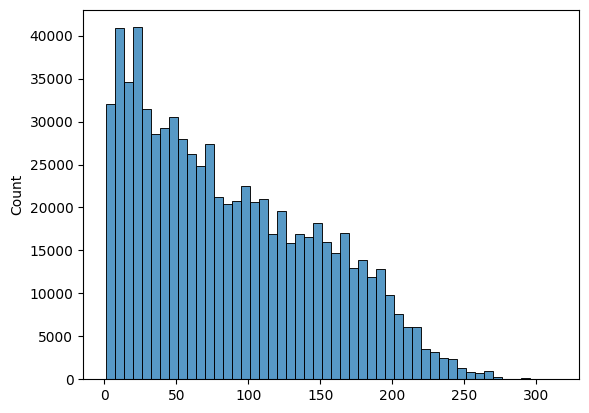

In [11]:
calories = df.calories.values
sns.histplot(calories, bins = 50) 

We see above that the calorie variable is not a random variable that is normally distributed. It looks like it has an exponential decay with a long tail. let's take the log of the data to tame it!

<Axes: ylabel='Count'>

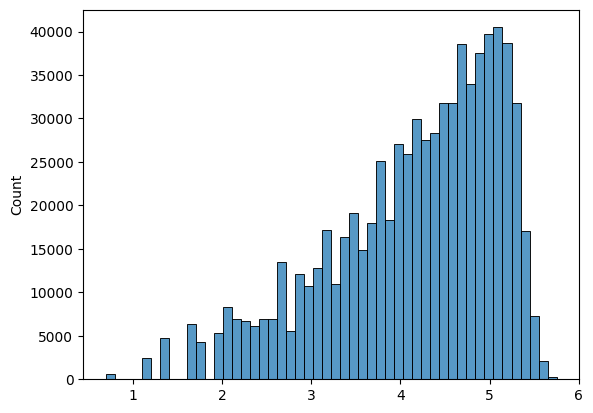

In [12]:
log_calories = np.log1p(calories)
sns.histplot(log_calories, bins = 50)

In [13]:
df.calories = log_calories 
df.calories.head()

0    5.017280
1    3.555348
2    3.401197
3    4.948760
4    4.990433
Name: calories, dtype: float64

### Correlation between Numerical Values

In [14]:
categorical = ['sex']
numerical = list(set(df.columns) - set(categorical))
print(numerical)

['height', 'weight', 'heart_rate', 'body_temp', 'age', 'calories', 'duration']


<Axes: >

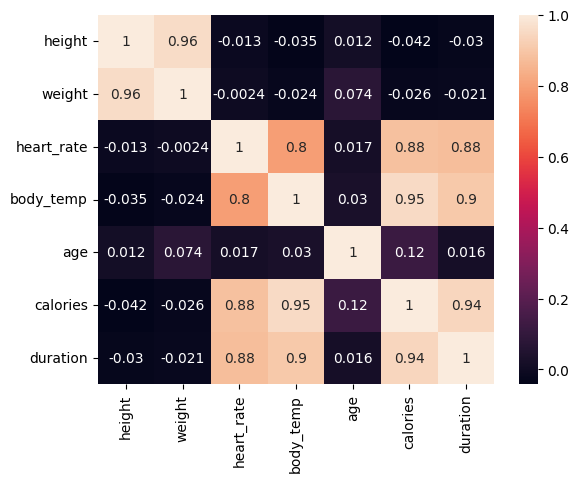

In [15]:
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix, annot = True)


What about the distribution of gender in terms of calories?

<Axes: xlabel='calories', ylabel='Probability'>

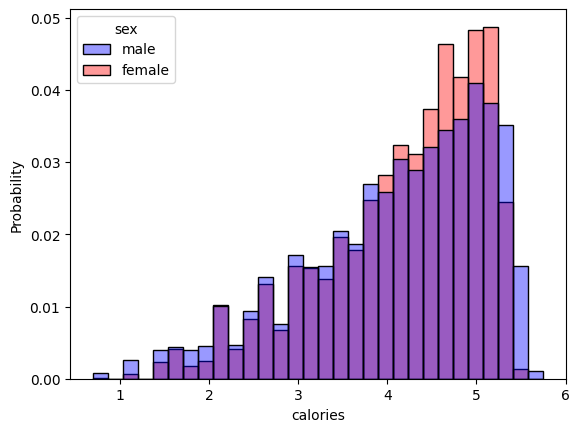

In [16]:
sns.histplot(data=df, x='calories', hue='sex', 
             palette={'male': 'blue', 'female': 'red'}, 
             alpha=0.4, bins=30, stat='probability')

The log_calories distribution per gender overlaps quite a lot with the male having a higher peak of probability for certain calories

In [17]:
df.describe()

,age,height,weight,duration,heart_rate,body_temp,calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,4.141144
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,0.963231
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,0.693147
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,3.555348
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,4.356709
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,4.919981
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,5.752573


In [18]:
df['sex'].value_counts()


sex
female    375721
male      374279
Name: count, dtype: int64

### Mutual Information Score

In [19]:
from sklearn.metrics import mutual_info_score

In [20]:
scores = mutual_info_score(df.calories, df.weight)
scores

/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


np.float64(0.06801325899704724)

In [21]:
def mutual_info_y_score(series):
    return mutual_info_score(series, df.calories)

mi = df[numerical].apply(mutual_info_y_score).round(5)
mi = mi.sort_values(ascending = False).to_frame(name = "MI")
mi

/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

,MI
calories,5.36087
duration,1.64379
body_temp,1.12536
heart_rate,0.98281
age,0.10861
height,0.06812
weight,0.06801


## Encoding the categorical Sex variable

### Option 1:
Let's encode the sex as {1,0}

In [22]:
df.sex = (df.sex == 'male').astype(int) ## { male: 1, female: 0}
df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,1,36,189.0,82.0,26.0,101.0,41.0,5.017280
1,0,64,163.0,60.0,8.0,85.0,39.7,3.555348
2,0,51,161.0,64.0,7.0,84.0,39.8,3.401197
3,1,20,192.0,90.0,25.0,105.0,40.7,4.948760
4,0,38,166.0,61.0,25.0,102.0,40.6,4.990433


## Preparing the Data splits of Train/Val/Test (60/20/20)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
df_fulltrain, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_fulltrain.shape, df_test.shape

((600000, 8), (150000, 8))

In [25]:
df_train, df_val = train_test_split(df_fulltrain, test_size = 0.25)
df_train.shape, df_val.shape

((450000, 8), (150000, 8))

In [26]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [27]:
## let's reset the index of the split data

df_fulltrain = df_fulltrain.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [28]:
df_test.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,0,56,163.0,61.0,29.0,108.0,40.8,5.303305
1,1,44,179.0,87.0,13.0,94.0,40.3,4.174387
2,1,41,186.0,84.0,10.0,89.0,39.9,3.688879
3,0,38,161.0,58.0,19.0,98.0,40.6,4.644391
4,1,57,181.0,77.0,9.0,98.0,40.0,3.970292


In [29]:
## Target variable

y_fulltrain = df_fulltrain.calories.values
y_train = df_train.calories.values
y_val = df_val.calories.values
y_test = df_test.calories.values

## delete the target variables

del df_fulltrain['calories']
del df_train['calories']
del df_val['calories']
del df_test['calories']

In [30]:
df_train.head(7)

,sex,age,height,weight,duration,heart_rate,body_temp
0,1,24,199.0,102.0,1.0,76.0,38.2
1,1,63,185.0,92.0,6.0,92.0,39.6
2,0,43,161.0,62.0,17.0,95.0,40.4
3,1,26,184.0,83.0,27.0,111.0,40.8
4,0,20,155.0,55.0,19.0,95.0,40.3
5,0,62,166.0,68.0,12.0,94.0,39.9
6,0,38,181.0,77.0,12.0,94.0,40.0


In [31]:
y_fulltrain[:7]

array([3.25809654, 4.21950771, 4.46590812, 1.79175947, 4.81218436,
       5.19295685, 5.07517382])

## Extract the Training Data Matrix

In [32]:
X_train = df_train.values
#print(X_train)
ones = np.ones(X_train.shape[0])
#print(ones)
X_train = np.column_stack([ones, X_train])
X_train

array([[  1. ,   1. ,  24. , ...,   1. ,  76. ,  38.2],
       [  1. ,   1. ,  63. , ...,   6. ,  92. ,  39.6],
       [  1. ,   0. ,  43. , ...,  17. ,  95. ,  40.4],
       ...,
       [  1. ,   1. ,  50. , ...,  22. , 100. ,  40.5],
       [  1. ,   1. ,  24. , ...,  14. , 100. ,  40.1],
       [  1. ,   1. ,  22. , ...,  10. ,  86. ,  39.8]])

In [33]:
X_train.shape, y_train.shape

((450000, 8), (450000,))

## Training a Linear Model 

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression()

In [36]:
model.fit(X_train, y_train)

LinearRegression()

In [37]:
x_trial = X_train[:2]
y_trial = model.predict(x_trial)
print(y_trial)

[1.92528068 3.62367042]


### Fit Parameters and interpretation

In [38]:
w0 = model.intercept_
print(w0)
w1 = model.coef_
print(w1)

-25.754856749058803
[ 0.         -0.06811536  0.00583767 -0.00178093  0.00262595  0.02708765
  0.02441321  0.67571244]


In [39]:
df_train.head()

,sex,age,height,weight,duration,heart_rate,body_temp
0,1,24,199.0,102.0,1.0,76.0,38.2
1,1,63,185.0,92.0,6.0,92.0,39.6
2,0,43,161.0,62.0,17.0,95.0,40.4
3,1,26,184.0,83.0,27.0,111.0,40.8
4,0,20,155.0,55.0,19.0,95.0,40.3


In [40]:
features_weights = {}

for i, c in enumerate(df_train.columns):
    features_weights[c] = w1[i+1]

print(features_weights)



{'sex': np.float64(-0.06811535983967978), 'age': np.float64(0.005837669149561916), 'height': np.float64(-0.0017809320732355013), 'weight': np.float64(0.002625951092241424), 'duration': np.float64(0.027087649816030724), 'heart_rate': np.float64(0.024413214646983705), 'body_temp': np.float64(0.6757124408655669)}


## Model Evaluation using Validation and Test Set

In [41]:
from sklearn.metrics import mean_squared_log_error

In [42]:
y_train_log_preds = model.predict(X_train)
y_train_preds= np.expm1(y_train_log_preds)
RMSE_train = np.sqrt(mean_squared_log_error(np.expm1(y_train), model.predict(X_train)))
RMSE_train

np.float64(2.6367886533834786)

### Validation Set

In [43]:
X_val = df_val.values
#print(X_train)
ones = np.ones(X_val.shape[0])
#print(ones)
X_val = np.column_stack([ones, X_val])
X_val

array([[  1. ,   1. ,  20. , ...,  10. ,  92. ,  40. ],
       [  1. ,   1. ,  44. , ...,  11. ,  91. ,  39.7],
       [  1. ,   1. ,  44. , ...,  22. ,  96. ,  40.5],
       ...,
       [  1. ,   1. ,  31. , ...,   9. ,  85. ,  39.8],
       [  1. ,   0. ,  69. , ...,  16. ,  95. ,  40.4],
       [  1. ,   0. ,  73. , ...,  28. , 110. ,  41. ]])

In [44]:
y_val_log_preds = model.predict(X_val)
y_val_preds= np.expm1(y_val_log_preds)
RMSE_val = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_val_preds))
RMSE_val

np.float64(0.1805905200078027)

### Test Set

In [45]:
X_test = df_test.values
ones = np.ones(X_test.shape[0])
X_test = np.column_stack([ones, X_test])
X_test

array([[  1. ,   0. ,  56. , ...,  29. , 108. ,  40.8],
       [  1. ,   1. ,  44. , ...,  13. ,  94. ,  40.3],
       [  1. ,   1. ,  41. , ...,  10. ,  89. ,  39.9],
       ...,
       [  1. ,   0. ,  37. , ...,   7. ,  96. ,  39.2],
       [  1. ,   0. ,  21. , ...,  10. ,  86. ,  39.7],
       [  1. ,   0. ,  40. , ...,  26. , 109. ,  41.1]])

In [46]:
y_test_log_preds = model.predict(X_test)
y_test_preds= np.expm1(y_test_log_preds)
RMSE_test = np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_preds))
RMSE_test

np.float64(0.17927341462304666)

In [47]:
## For ease of use, I define a custom function that does this

def get_RMSLE(y_true_logs, X_matrix, model):
    y_pred_logs = model.predict(X_matrix)
    y_preds = np.expm1(y_pred_logs)
    y_trues = np.expm1(y_true_logs)
    return np.sqrt(mean_squared_log_error(y_trues, y_preds))

print(get_RMSLE(y_test, X_test, model))

0.17927341462304666


## Applying the Simple trained model on the Submission data

In [48]:
df_submission = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

In [49]:
df_submission.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [50]:
df_submission.columns = df_submission.columns.str.lower().str.replace(' ', '_')
df_submission.columns

Index(['id', 'sex', 'age', 'height', 'weight', 'duration', 'heart_rate',
       'body_temp'],
      dtype='object')

In [51]:
df_submission.sex = (df_submission.sex == 'male').astype(int)
df_submission.head()

,id,sex,age,height,weight,duration,heart_rate,body_temp
0,750000,1,45,177.0,81.0,7.0,87.0,39.8
1,750001,1,26,200.0,97.0,20.0,101.0,40.5
2,750002,0,29,188.0,85.0,16.0,102.0,40.4
3,750003,0,39,172.0,73.0,20.0,107.0,40.6
4,750004,0,30,173.0,67.0,16.0,94.0,40.5


In [52]:
sub_features = list(features_weights)
sub_features

['sex', 'age', 'height', 'weight', 'duration', 'heart_rate', 'body_temp']

In [53]:
## Data Matrix for Submission

X_sub = df_submission[sub_features].values
ones = np.ones(X_sub.shape[0])
X_sub = np.column_stack([ones, X_sub])
X_sub

array([[  1. ,   1. ,  45. , ...,   7. ,  87. ,  39.8],
       [  1. ,   1. ,  26. , ...,  20. , 101. ,  40.5],
       [  1. ,   0. ,  29. , ...,  16. , 102. ,  40.4],
       ...,
       [  1. ,   0. ,  31. , ...,  14. ,  98. ,  40.1],
       [  1. ,   0. ,  62. , ...,  25. , 106. ,  40.7],
       [  1. ,   1. ,  31. , ...,  15. ,  98. ,  39.9]])

In [54]:
y_sub_log = model.predict(X_sub)
y_sub_preds = np.expm1(y_sub_log)
y_sub_preds

array([ 33.60916162,  98.60174266,  91.31061787, ...,  63.70833484,
       190.01707625,  54.44644668])

In [55]:
df_sub = np.column_stack([df_submission.id.values, y_sub_preds])
df_sub

array([[7.50000000e+05, 3.36091616e+01],
       [7.50001000e+05, 9.86017427e+01],
       [7.50002000e+05, 9.13106179e+01],
       ...,
       [9.99997000e+05, 6.37083348e+01],
       [9.99998000e+05, 1.90017076e+02],
       [9.99999000e+05, 5.44464467e+01]])

In [56]:
df_sub = pd.DataFrame(df_sub)
df_sub.head()


,0,1
0,750000.0,33.609162
1,750001.0,98.601743
2,750002.0,91.310618
3,750003.0,139.622434
4,750004.0,79.054626


In [57]:
df_sub = pd.DataFrame(df_sub)
df_sub.columns = ['id', 'Calories']
df_sub.id = df_sub.id.astype(int)
df_sub.head()

,id,Calories
0,750000,33.609162
1,750001,98.601743
2,750002,91.310618
3,750003,139.622434
4,750004,79.054626


In [58]:
# ## let's export the predictions
# df_sub.to_csv('submission.csv', index=False)


The simple linear regression model we have trained above only yields a score of 0.174 which is around ~ 3000 - 4000 in terms of ranking. So our model is not the ideal one. Let's keep iterating and improving!


## Continued: Regularised Linear Regression

### Option 1: Custom regularisation by adding values along the diagonal

In [59]:
c = 0.1
X_train_reg = X_train + c * np.eye(*X_train.shape)
X_train_reg

array([[  1.1,   1. ,  24. , ...,   1. ,  76. ,  38.2],
       [  1. ,   1.1,  63. , ...,   6. ,  92. ,  39.6],
       [  1. ,   0. ,  43.1, ...,  17. ,  95. ,  40.4],
       ...,
       [  1. ,   1. ,  50. , ...,  22. , 100. ,  40.5],
       [  1. ,   1. ,  24. , ...,  14. , 100. ,  40.1],
       [  1. ,   1. ,  22. , ...,  10. ,  86. ,  39.8]])

In [60]:
y_train_reg = y_train.copy()
y_train_reg

array([1.09861229, 3.58351894, 4.47733681, ..., 4.97673374, 4.2341065 ,
       3.4657359 ])

In [61]:
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

LinearRegression()

In [62]:
w0_reg = model.intercept_
w1_reg = model.coef_
print(w0_reg)
print(w1_reg)

-25.754856749058803
[ 0.         -0.06811536  0.00583767 -0.00178093  0.00262595  0.02708765
  0.02441321  0.67571244]


In [63]:
model_reg.score(X_val, y_val)

0.9647280108576327

In [64]:
## Validation
y_val_preds_log = model_reg.predict(X_val)
#print(y_val_preds_log)

y_val_preds = np.expm1(y_val_preds_log)

reg_scores = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_val_preds))
print(reg_scores)

0.18059050450529812


Okay this added regulariser doesn't do much!, Let's define a function that goes through possible values of c and store their performance

In [65]:
## 
from tqdm.auto import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
y_val

array([3.58351894, 3.95124372, 4.74493213, ..., 3.4657359 , 4.48863637,
       5.3082677 ])

In [67]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
scores = []

for c in tqdm(C):
    model_reg = LinearRegression()
    X_train_c = X_train + c * np.eye(*X_train.shape)
    y_train = y_train
    model_reg.fit(X_train_c, y_train)
    ##Validatiion set
    sub_score = get_RMSLE(y_val, X_val, model_reg)
    print(f'C: {c}, score: {sub_score}')
    scores.append(sub_score)

print(scores)

  0%|          | 0/6 [00:00<?, ?it/s]

C: 0.001, score: 0.18059050598874382


 17%|█▋        | 1/6 [00:00<00:00,  5.31it/s]

C: 0.01, score: 0.18059050588428133


 33%|███▎      | 2/6 [00:00<00:00,  4.19it/s]

C: 0.1, score: 0.18059050450529812


 50%|█████     | 3/6 [00:00<00:00,  4.80it/s]

C: 1, score: 0.1805904573675642


 67%|██████▋   | 4/6 [00:00<00:00,  4.24it/s]

C: 10, score: 0.18058724166422271


 83%|████████▎ | 5/6 [00:01<00:00,  4.73it/s]

C: 100, score: 0.18415805247499162


100%|██████████| 6/6 [00:01<00:00,  4.43it/s]


[np.float64(0.18059050598874382), np.float64(0.18059050588428133), np.float64(0.18059050450529812), np.float64(0.1805904573675642), np.float64(0.18058724166422271), np.float64(0.18415805247499162)]


We see from our analysis above, that this method of regularisation doesn't yield much improvement 

## Random Forest Model

In [76]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=10, random_state=0)

In [77]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [78]:
y_pred_log_rf = rf_model.predict(X_val)
y_pred_log_rf

array([3.65510625, 3.91970712, 4.72303676, ..., 3.3375585 , 4.48826078,
       5.32744373])

In [79]:
print(get_RMSLE(y_test, X_test, rf_model))

0.06626650480903006


## Generating the Submission data

In [69]:
### Submission Generator Function

def generate_submission(df_sub, model):
    X_sub = df_submission[sub_features].values
    ones = np.ones(X_sub.shape[0])
    X_sub = np.column_stack([ones, X_sub])

    y_sub_log = model.predict(X_sub)
    y_sub_preds = np.expm1(y_sub_log)
    
    df_sub = np.column_stack([df_submission.id.values, y_sub_preds])
    df_sub = pd.DataFrame(df_sub)
    df_sub.columns = ['id', 'Calories']
    df_sub.id = df_sub.id.astype(int)

    return df_sub


In [86]:
sub__ = generate_submission(df_submission, rf_model)

In [87]:
sub__.head()

,id,Calories
0,750000,27.272254
1,750001,107.848384
2,750002,86.543355
3,750003,124.682961
4,750004,76.062444


In [88]:
## Export Submssion
sub__.to_csv('submission.csv', index = False)